<a href="https://colab.research.google.com/github/husnain-ali21/Learning3D/blob/main/images2meshes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/im2mesh

/content/drive/MyDrive/im2mesh


In [ ]:
#@title Installing all dependencies and Packages first for the model.

%%bash
# Install Conda
# Refer: https://linuxize.com/post/how-to-install-anaconda-on-ubuntu-18-04/
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

# Install pytorch, torchvision, trimesh and NeuralODE Solver
conda install -y -c pytorch pytorch torchvision cudatoolkit=10.1
conda install -y -c conda-forge pyembree
conda install -y -c conda-forge trimesh seaborn
#pip install git+https://github.com/rtqichen/torchdiffeq torchvision
pip install torchdiffeq

#https://drive.google.com/file/d/1XXQDdEW5aLGYMmNDMb6t_py5F2B1hyQp/view?usp=sharing

wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XXQDdEW5aLGYMmNDMb6t_py5F2B1hyQp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XXQDdEW5aLGYMmNDMb6t_py5F2B1hyQp" -O data.zip && rm -rf /tmp/cookies.txt
unzip -o data.zip
rm data.zip
rm Miniconda3-4.5.4-Linux-x86_64.sh


In [ ]:

!pip install torchdiffeq
#@title Add packages to python path
import sys
_ = (sys.path
        .append("/usr/local/lib/python3.6/site-packages"))




The following is code used to implement this pipeline 

In [ ]:
!python3 -m pip install torchdiffeq


In [ ]:
!python -m pip install trimesh

     |████████████████████████████████| 634kB 11.4MB/s 


In [ ]:
# Load the required libraries

import torch
import torch.nn as nn
import numpy as np
from torchdiffeq import odeint_adjoint as odeint
import torch.nn.functional as F
import torchvision.models as models
import trimesh

In [ ]:
class Encoder(nn.Module):
    '''
    PointNet Encoder by Qi. et.al
    '''
    def __init__(self, zdim, input_dim=3):
        super(Encoder, self).__init__()
        
        self.zdim = zdim
        self.conv1 = nn.Conv1d(input_dim, 128, 1)
        self.conv2 = nn.Conv1d(128, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        self.conv4 = nn.Conv1d(256, zdim, 1)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(zdim)

        self.fc1 = nn.Linear(zdim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc_bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, zdim)
        

    def forward(self, x):
        '''
        Input: Nx#ptsx3
        Output: Nxzdim
        '''
        x = x.transpose(1, 2)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.bn4(self.conv4(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, self.zdim)

        
        ms = F.relu(self.fc_bn1(self.fc1(x)))
        ms = F.relu(self.fc_bn2(self.fc2(ms)))
        ms = self.fc3(ms)

        return ms

class PointsSVR(nn.Module):
    '''
    To allow single-view reconstruction. We estimate a sparse point cloud from the input image which is then fed to NMF pipeline.
    Refer Section 3 (Implementation details)
    '''
    
    def __init__(self):
        super(PointsSVR, self).__init__()
        '''
        Initialization
        '''
        # We use a pretrained resent18 for encoding images.
        self.encoder = models.resnet.resnet18(pretrained=True).float()
        
        # Decoder yields a point cloud with 1024 points
        self.decoder = nn.Sequential(nn.Linear(1000,2000),nn.ReLU(),
                                     nn.Linear(2000,2000),nn.ReLU(),
                                     nn.Linear(2000,1024*3))
        
    def forward(self, img):
        '''
        img: Bx3xKxK input tensor
        '''
        batch_size = img.shape[0]
        assert img.device != 0, print(" Input is on CPU")
        
        code = self.encoder(img).unsqueeze(1)
        shape = self.decoder(code).reshape(batch_size,-1,3)
        
        # Center the point cloud
        shape = shape - torch.mean(shape, axis=1, keepdim=True)
        return shape


In [ ]:
class ODEFunc(nn.Module):
    '''
    This refers to the dynamics function f(x,t) in a IVP defined as dh(x,t)/dt = f(x,t). 
    For a given location (t) on point (x) trajectory, it returns the direction of 'flow'.
    Refer to Section 3 (Dynamics Equation) in the paper for details. 
    '''
    def __init__(self, num_hidden = 512, latent_len = 512):
        '''
        Initialization. 
        num_hidden: number of nodes in a hidden layer
        latent_len: size of the latent code being used
        '''
        
        super(ODEFunc, self).__init__()
        
        self.l1 = nn.Linear(3, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_hidden)   
        self.l3 = nn.Linear(num_hidden, num_hidden)
        self.l4 = nn.Linear(num_hidden, 3)
        
        self.cond = nn.Linear(latent_len, num_hidden) 

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
        self.nfe = 0
        self.zeros = torch.zeros((1, 1, latent_len))
        self.latent_dyn_zeros=None
#         self.tw = nn.Linear(1, num_hidden)
        
    def forward(self, t, xz):
        '''
        t: Torch tensor of shape (1,) 
        xz: Torch tensor of shape (N, #pts, 3+zdim). Along dimension 2, the point and shape embeddings are concatenated. 
        
        **NOTE**
        For the uniqueness property to hold, a single dynamics function (operating in 3D) must be used to compute 
        trajectories pertaining to points of a single shape. 
        
        Here, the shape encoding (same for all points of a shape) is used to choose a function which is applied over all the shape points.
        Hence, even though the input xz appears to be a 3+zdim dimensional state, the ODE is still restricted to a 3D state-space. 
        The concatenation is purely to make programming simpler without affecting the underlying theory. 
        
        '''
        point_features = self.relu(self.l1((xz[...,:3]))) # Extract point features Nx#ptsx3 -> Nx#ptsx512
        shape_features = self.tanh(self.cond(xz[...,3:]))  # Extract shape features Nx#ptsxzdim -> Nx#ptsx512
        
        point_shape_features = point_features*shape_features  # Compute point-shape features by elementwise multiplication
        # [Insight :]  Conditioning is critical to allow for several shapes getting learned by same NeuralODE. 
        #              Note that under current formulation, all points belonging to a shape share a common dynamics function.
        
        # Two residual blocks
        point_shape_features = self.relu(self.l2(point_shape_features)) + point_shape_features
        point_shape_features = self.relu(self.l3(point_shape_features)) + point_shape_features
        # [Insight :] Using less residual blocks leads to drop in performance
        #             while more residual blocks make model heavy and training slow due to more complex trajectories being learned.
        
        dyns_x_t = self.tanh(self.l4(point_shape_features)) #Computed dynamics of point x at time t
        # [Insight :] We specifically choose a tanh activation to get maximum expressivity as observed by He, et.al and Massaroli, et.al
        
        self.nfe+=1  #To check #ode evaluations
        
        # To prevent updating of latent codes during ODESolver calls, we simply make their dynamics all zeros. 
        if self.latent_dyn_zeros is None or self.latent_dyn_zeros.shape[0] != dyns_x_t.shape[0]:
            self.latent_dyn_zeros = self.zeros.repeat(dyns_x_t.shape[0],dyns_x_t.shape[1],1).type_as(dyns_x_t)  
        
        return torch.cat([dyns_x_t, self.latent_dyn_zeros], dim=2) # output is therefore like [dyn_x, dyn_y, dyn_z, 0,0..,0] for a point

In [ ]:
class NODEBlock(nn.Module):
    '''
    Function to solve an IVP defined as dh(x,t)/dt = f(x,t). 
    We use the differentiable ODE Solver by Chen et.al used in their NeuralODE paper.
    '''
    def __init__(self, odefunc, tol):
        '''
        Initialization. 
        odefunc: The dynamics function to be used for solving IVP
        tol: tolerance of the ODESolver
        '''
        super(NODEBlock, self).__init__()
        self.odefunc = odefunc
        self.cost = 0
        self.rtol = tol
        self.atol = tol
        
    def forward(self, x, time):
        '''
        Solves the ODE in the forward time. 
        '''
        self.odefunc.nfe = 0  #To check #ode evaluations
        self.forward_time = torch.tensor([0, time]).float().type_as(x)  # Time of integration (must be monotinically increasing!)
        # Solve the ODE with initial condition x and interval time.
        out = odeint(self.odefunc.to(x), x, self.forward_time, rtol = self.rtol, atol = self.atol)
        self.cost = self.odefunc.nfe  # Number of evaluations it took to solve it
        return out[1] 
    
    def invert(self, x, time):
        '''
        Solves the ODE in the reverse time. 
        '''
        self.inverse_time = torch.tensor([time, 0]).float().type_as(x)
        out = odeint(self.odefunc, x, self.inverse_time, rtol = self.rtol, atol = self.atol)
        self.cost = self.odefunc.nfe
        return out[1]

In [ ]:
class DeformBlock(nn.Module):
    '''
    A single DeformBlock is made up of two NODE Blocks. Refer secion 3 (Overall Architecture)
    '''
    def __init__(self, time=0.2, num_hidden = 512, latent_len = 512, tol = 1e-5):
        super(DeformBlock, self).__init__()
        '''
        Initialization.
        time: some number 0-1
        num_hidden: Number of hidden nodes in the MLP of dynamics
        latent_len: Length of shape embeddings
        tol: tolerance of the ODE Solver
        '''
        
        # Two NODE Blocks
        self.l1 = NODEBlock(ODEFunc(num_hidden, latent_len), tol = tol)
        self.l2 = NODEBlock(ODEFunc(num_hidden, latent_len), tol = tol)
        
        self.time = time
        
    def forward_(self, x, code, time=None):
        '''
        Forward flow method
        
        x: BxNx3 input tensor
        code: Bxzdim tensor embedding
        time: some number 0-1
        
        y: BxNx3 output tensor
        '''
        
        if time is None:
            time=self.time
            
        xz = torch.cat([x, code.repeat(1,x.shape[1],1)],dim=2)
        # Note: To enable condioned flows, we concatenate points with their corresponding shape embeddings. 
        #       Refer to code comments in ODEFunc.forward() for more details about this choice.

        x = self.l1(xz, time)
        x = self.l2(x, time)
        
        y = x[...,:3]  # output the corresponding 'flown' points.
        return y
    
    def backward_(self, x, code, time=None):
        '''
        Backward flow method
        
        x: BxNx3 input tensor
        code: Bxzdim tensor embedding
        time: some number 0-1
        
        y: BxNx3 output tensor
        
        **NOTE** We do not use this method in the main NMF pipeline, but may come handy for things like inverting the NMF!
        
        '''
        if time is None:
            time=self.time
            
        xz = torch.cat([x, code.repeat(1,x.shape[1],1)],dim=2)
        # Note: To enable condioned flows, we concatenate points with their corresponding shape embeddings. 
        #       Refer to code comments in ODEFunc.forward() for more details about this choice.

        x = self.l2.invert(xz, time)
        x = self.l1.invert(x, time)
        
        y = x[...,:3]
        
        return y
    
    def forward(self, code, x, y=None, time=None):
        '''
        code: Bxzdim tensor embedding
        x: BxNx3 input tensor
        y: BxNx3 output tensor
        time: some number 0-1
        '''
        
        # Calculate forward flow
        pred_y = self.forward_(x,code,time)
        
        
        if y is not None:
            # Calculate backward flow if required
            pred_x = self.backward_(y,code,time)
            return pred_y, pred_x
        
        return pred_y, None

In [ ]:
class InstanceNorm(nn.Module):
    '''
    Instance Normalization. Refer Section 3 in paper (Instance Normalization) for more details and Fig 5 for visual intuition.
    This is crucial for cross-category training.
    '''
    def __init__(self, zdim):
        super(InstanceNorm, self).__init__()
        '''
        Initialization.
        '''
        self.norm = nn.Sequential(nn.Linear(zdim, 256), nn.ReLU(), nn.Linear(256, 3), nn.Sigmoid()).float()
        
    def forward(self, input, code):
        '''
        input: point cloud of shape BxNx3
        code: shape embedding of shape Bx1xzdim
        '''
        centered_input = input - torch.mean(input, axis=1, keepdim=True)   # Center the point cloud
        centered_input = centered_input*(1-self.norm(code))    # anisotropic scaling the point cloud w.r.t. the shape embedding
        
        return centered_input

In [ ]:

class NeuralMeshFlow(nn.Module):
    '''
    Implementation of the Neural Mesh Flow pipeline.
    '''
    def __init__(self, encoder_type = 'image', PATH_svr = './data/nmf_svr', zdim=1000, time=0.2, tol = 1e-5):
        super(NeuralMeshFlow, self).__init__()
        '''
        Initialization
        encoder_type: 'image' or 'point' for SVR and shape completion tasks repectively
        PATH_svr: model file for trained PointsSVR
        zdim: length of latent embedding
        time: some number 0-1
        tol: tolerance of ODESolver.
        '''
        
        '''
        **** NOTE on design choices  ******
        
        zdim : We did not observe much benefit of increased latent embedding size (i.e. >1000) and it simply increases memory requirement
        time : time of integration (set to 0.2) is chosen since it is long enough for effective integration but not too large to cause complex dynamics
        tol  : A lower tol is always better but comes at a cost of inference time. Refer to ablation in Supplementary for this.

        '''

        print("Neural Mesh Flow with {} length embedding initialized".format(zdim))
        
        # Three deform blocks to cause successive refinements. Refer Section 3 (Overal architecture)
        self.db1 = DeformBlock(time, num_hidden = 512, latent_len = zdim, tol=tol)
        self.db2 = DeformBlock(time, num_hidden = 512, latent_len = zdim, tol=tol)
        self.db3 = DeformBlock(time, num_hidden = 512, latent_len = zdim, tol=tol)
        
        # Template spheres for training/testing. 
        
        # [Insight :] While trainig with smaller (#vertices) sphere is faster, inference with larger sphere is more accurate. 
        # Choosing spheres with even lower vertices can cause drop in performance due to unstable optimization. 
        # Using #vertices >2520 doesn't yeild much benefit and takes more training time.
        
        # These spheres are generated using Pymesh library : pymesh.generate_icosphere(radius=1, center=(0,0,0), refinement_order=3 or 4)
        
        self.sph_train = trimesh.load('./data/mypymeshsph_3.obj')  # Unit sphere with 622 vertices
        self.sph_test  = trimesh.load('./data/mypymeshsph_4.obj')   # Unit sphere with 2520 vertices
        
        # Convert faces and vertices to torch. Face information will later be used for generating differentiable meshes.
        self.f = [torch.from_numpy(self.sph_train.faces).int(), torch.from_numpy(self.sph_test.faces).int()] # Faces
        self.v = [torch.from_numpy(self.sph_train.vertices), torch.from_numpy(self.sph_test.vertices)]       # Vertices
        
        self.time = time  
        
        # For SVR task, we require an additional image encoder. 
        if encoder_type == 'image':
            print("Choosing image encoder")
            
            pointmodel = nn.DataParallel(PointsSVR()).float()  # Use PointsSVR to get point cloud initialization
            pointmodel.load_state_dict(torch.load(PATH_svr))  # Load pretrained weights for PointsSVR
            self.svr = pointmodel
            self.encoder = Encoder(zdim).float()            # Initialize PointNet encoder 
        
        # For shape completion, we require only points encoder.
        elif encoder_type == 'point':
            print("Choosing Point Encoder")
            self.encoder = Encoder(zdim).float()  # Initialize PointNet encoder
        else:
            print(" Invalid choice of encoder!! ")

        # Initialize InstanceNorm layers
        self.norm0 = InstanceNorm(zdim)
        self.norm1 = InstanceNorm(zdim)
        self.norm2 = InstanceNorm(zdim)
        self.norm3 = InstanceNorm(zdim)
        
    def get_code_(self, x):
        '''
        Fetch the shape embeddings for point clouds in x
        x: BxNx3 input tensor
        code: Bx1xzdim tensor embedding
        '''
        code = self.encoder(x)
        code = code.unsqueeze(1)
        
        return code

    def forward(self, input, time=None):
        '''
        input: BxNx3 tensor
        pred_y1: BxNx3 tensor; vertices after first deformation block
        pred_y2: BxNx3 tensor; vertices after second deformation block
        pred_y3: BxNx3 tensor; vertices after third deformation block
        face: BxKx3; faces to be used for constructing differentiable meshes
        '''
        batch_size = input.shape[0]
        assert input.device != 0, print(" Input is on CPU")
        
        if len(input.shape) == 4:
            # Input is an image
            # First predict a sparse point cloud from this image
            pts_init = self.svr(input).type_as(input)
            # Center this point cloud
            pts_init = pts_init - torch.mean(pts_init, axis=1, keepdim=True)
            # Now get the shape embedding from this point cloud
            code = self.get_code_(pts_init).type_as(input)
        else:
            # Input is a (centered) point cloud. Directly compute its embedding
            code = self.get_code_(input).type_as(input) # Get latent code using point cloud at native resolution
                  
        # Use smaller sphere (622 vertices) for training otherwise use a larger sphere (2520 vertices) for testing
        sphidx = 0 if self.training else 1
        sph = self.v[sphidx].unsqueeze(0).repeat(batch_size,1,1).type_as(input)
        face = self.f[sphidx].unsqueeze(0).repeat(batch_size,1,1).type_as(input)
        
        # Apply instance norm to input sphere
        sph = self.norm0(sph, code)
        
        # First Deform Block computation and its instance norm
        pred_y1, _ = self.db1(code, sph, None, time)
        pred_y1 = self.norm1(pred_y1, code)
        
        # Second Deform Block computation and its instance norm
        pred_y2, _ = self.db2(code, pred_y1, None, time)
        pred_y2 = self.norm2(pred_y2, code)
        
        # Third Deform Block computation and its instance norm
        pred_y3, _ = self.db3(code, pred_y2, None, time)
        pred_y3 = self.norm3(pred_y3, code)
        
        return pred_y1, pred_y2, pred_y3, face

In [ ]:
#@title Some code for I/O of model 
import imageio
import matplotlib.pyplot as plt

def read_color_image(filename):
    return np.array(imageio.imread(filename))[...,:3]


def normalize_imagenet(x):
    ''' Normalize input images according to ImageNet standards.
    Args:
        x (tensor): input images
    '''
    x = x.clone()
    x[:, 0] = (x[:, 0] - 0.485) / 0.229
    x[:, 1] = (x[:, 1] - 0.456) / 0.224
    x[:, 2] = (x[:, 2] - 0.406) / 0.225
    return x 

def load_partial_pretrained(mymodel, path):
    '''
    Helps to load pretrained weights of model from a path.
    mymodel: model to be used
    path: path to the pretrained weights
    *** NOTE ***
    Sometimes this function ends up not loading any wieghts because of the mismatch in the weight-keys of model and pretrained weights. So if you encounter anything like that make sure to print the respective keys and match them!
    '''
    pretrained_dict = torch.load(path)
    model_dict = mymodel.state_dict()

    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

    model_dict.update(pretrained_dict) 
    mymodel.load_state_dict(model_dict)

In [ ]:
encoder_type = 'image'   # Set encoder type to images
model = nn.DataParallel(NeuralMeshFlow(encoder_type = encoder_type)).cuda()   # Initialize NMF model
load_partial_pretrained(model,'./data/nmf_ae')             # Load pretrained weights 
model.eval();      # Set NMF to evaluation mode

Neural Mesh Flow with 1000 length embedding initialized
Choosing image encoder


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


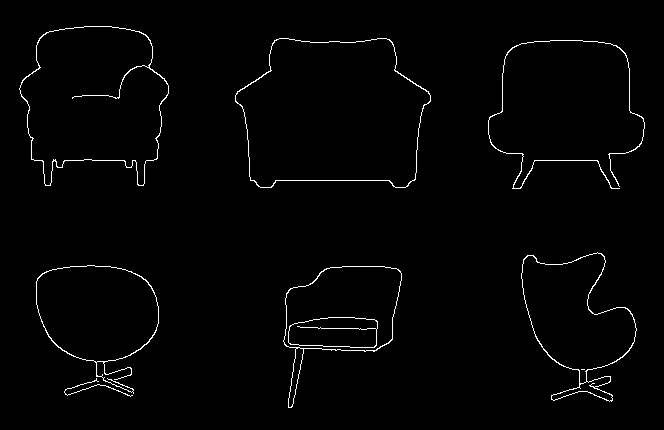

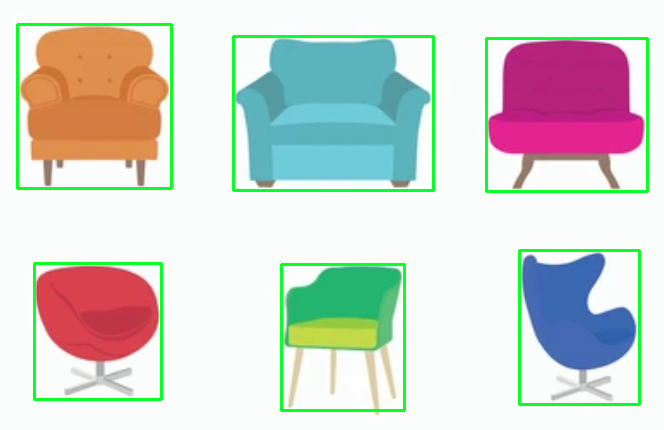



+=+=+= 6 OBJECTS DETECTED =+=+= : 


In [ ]:
#objects extraction 
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
def object_extraction(path):
    path = path
    image = cv2.imread(path)
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    canny = cv2.Canny(blurred, 50, 200, 1)
    kernel = np.ones((5,5),np.uint8)
    dilate = cv2.dilate(canny, kernel, iterations=1)

    # Find contours
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Iterate thorugh contours and filter for ROI
    image_number = 0
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
        ROI = original[y:y+h, x:x+w]
        cv2.imwrite("ROI_{}.png".format(image_number), ROI)
        image_number += 1
    ### """
    cv2_imshow(canny)
    cv2_imshow( image)
    cv2.waitKey(0)
    print(f"\n\n+=+=+= {image_number} OBJECTS DETECTED =+=+= : " )
    return image_number

path  =  "/content/drive/MyDrive/MRCNN/imagefur.png"
no_of_objects = object_extraction(path)


In [ ]:
import os, sys
from google.colab import drive
#drive.mount('/content/drive')
pytorch3d_path = '/content/drive/MyDrive/Colab Notebooks'

#os.symlink('/content/drive/My Drive/Colab Notebooks', pytorch3d_path)
sys.path.insert(0,pytorch3d_path)


In [ ]:
import time
from pytorch3d.structures import Meshes
from pytorch3d.io import save_obj
from pytorch3d.vis.plotly_vis import plot_scene , plot_batch_individually

def generate_meshes(I,  save =False):
        
        I = I.astype(np.float64)/255.0   # Convert image (0-255, int) to (0-1, float)
        I = torch.from_numpy(I)
        I = normalize_imagenet(I).transpose(0,2).float().unsqueeze(0)   # Normalize w.r.t. Imagenet stats and (H,W,3) -> (3,H,W) for adequate training
        p1 ,p2,pred, face = model(I)
        # Export predicted mesh using trimesh
        vertices = p2[0,...].detach().cpu()
        faces = face[0,...].detach().cpu()
        
        if save :
            final_obj_path = os.path.join('./', f"mesh_of_object_{obj}.obj")
            save_obj(final_obj_path, final_verts, final_faces)
        return vertices , faces
def show_meshes(mesh ):
       fig = plot_batch_individually(mesh)
        # we can update the figure height and width
       fig.update_layout(height=1000, width=1000)
       fig.show()

In [ ]:
verts_list , faces_list = [] , []
for obj in range(no_of_objects):
    Im  = read_color_image("ROI_{}.png".format(obj))
   # cv2_imshow(Im)
    print(f"Generating a Mesh for object {obj}")
    v , f = generate_meshes(Im)
    verts_list.append(v)
    faces_list.append(f)

meshes = Meshes(verts = verts_list , faces = faces_list)  




In [ ]:
show_meshes(meshes)
